### Импорт библиотек и датасетов

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
X = pd.read_csv('resources/features.tsv',sep='\t')
Y = pd.read_csv('resources/validate_answers.tsv',sep='\t')

### Черновая модель

In [3]:
X = X.drop(['publishers','user_ids'], axis=1)

In [4]:
from metrics import get_smoothed_mean_log_accuracy_ratio, get_smoothed_log_mape_column_value

def get_metric_for_ndarray(y_true, y_predicted):
    ans = get_smoothed_mean_log_accuracy_ratio(
        pd.DataFrame((y_true>0) * y_true, columns=Y.columns),
        pd.DataFrame((y_predicted>0) * y_predicted, columns=Y.columns)
    )
    return ans

def get_metric_for_one(y_true, y_predicted):
    return get_smoothed_log_mape_column_value((y_predicted>0)*y_predicted, (y_true>0)*y_true, 0.005)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=69)
X_train = X_train.fillna(0)
normalizer_x = StandardScaler().fit(X_train)
X_train = normalizer_x.transform(X_train)


In [ ]:
from sklearn.linear_model import MultiTaskElasticNet
# from sklearn.svm import SVR

# Импорт класса GridSearchCV из модуля model_selection scikit-learn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Создание словаря, содержащего потенциальные значения альфа
param_grid_en = {
    'alpha' : [0.001, 0.005, 0.008, 0.01, 0.03, 0.05, 0.1, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 5, 8, 10, 20, 50, 100],
    'l1_ratio' : [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.99, 0.999, 1],
    'max_iter' : [10000]
}

param_grid_svm = {
    'kernel' : ['linear', 'poly', 'rbf'],
    'degree' : [1, 2, 3, 4, 5],
    'gamma' : ['scale', 'auto'],
    'epsilon' : [1e-5, 0.001, 0.01, 0.1],
    'coef0' : [0, 1],
    'tol' : [1e-5, 1e-3, 0.1],
}

# Передача в GridSearchCV модели, потенциальных альфа-значений,
# метрики качества
model = GridSearchCV(MultiTaskElasticNet(),
                     param_grid_en,
                     scoring=make_scorer(get_metric_for_ndarray, greater_is_better=False),
                     #scoring='explained_variance',
                     cv=10)

res = model.fit(X_train, Y_train.values)
#res = model.fit(X_train, Y_train.values[:,0])

# обучение модели 
print('Лучшее значение alpha:', res.best_params_)

# Вывод метрики качества
print('Метрика качества:', res.best_score_)

Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "c:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 563, in run
    result_item, is_broken, bpe = self.wait_result_broken_or_wakeup()
  File "c:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 617, in wait_result_broken_or_wakeup
    ready = wait(readers + worker_sentinels)
  File "c:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 884, in wait
    ready_handles = _exhaustive_wait(waithandle_to_obj.keys(), timeout)
  File "c:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 816, in _exhaustive_wait
    res = _winapi.WaitForMultipleObjects(L, False, timeout)
ValueError: need at most 63 handles, got a sequence of length 101


Переназначаем индексы для корректной работы метрики

In [7]:
Y_train = Y_train.reset_index(drop=True)

In [8]:
preds = pd.DataFrame(model.predict(X_train),columns=Y.columns)
#preds = pd.DataFrame(np.array([model.predict(X_train), model2.predict(X_train), model3.predict(X_train)]).T,columns=validate_answers.columns)
preds = (preds>0)*preds

print('train result', get_smoothed_mean_log_accuracy_ratio( Y_train, preds))

train result 118.45


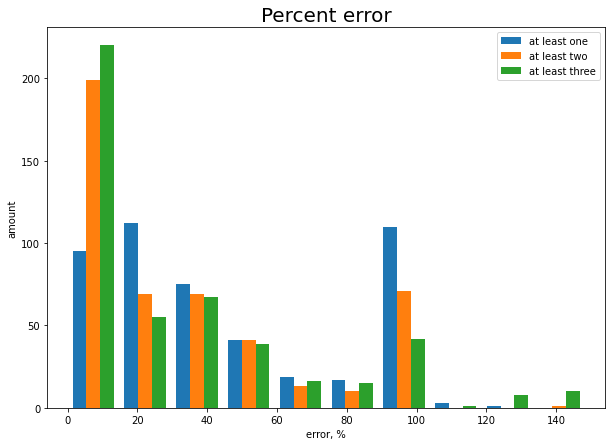

In [9]:
f = plt.figure(facecolor='white')
f.set_figwidth(10)
f.set_figheight(7)

plt.title('Percent error', fontsize = 20)
plt.xlabel('error, %')
plt.ylabel('amount')

ae = (Y_train - preds).abs()
pe = ae/(Y_train+0.0001)*100
plt.hist(pe[((pe<150)).all(axis=1)], bins=10)
plt.legend(['at least one', 'at least two', 'at least three'])
plt.show()

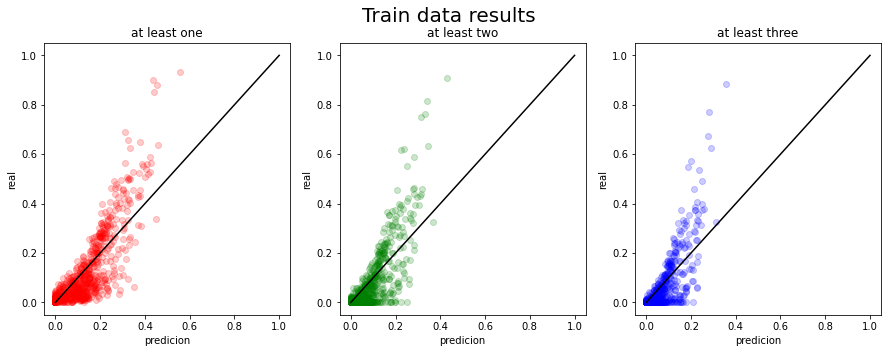

In [10]:
f = plt.figure(facecolor='white')
f.set_figwidth(15)
f.set_figheight(5)

plt.suptitle('Train data results', fontsize = 20)
plt.subplot(1,3,1)
plt.scatter(preds['at_least_one'], Y_train['at_least_one'], color='r', alpha=0.2,)
plt.title('at least one')
plt.plot([0,1],[0,1], 'k')
plt.xlabel('predicion')
plt.ylabel('real')

plt.subplot(1,3,2)
plt.scatter(preds['at_least_two'], Y_train['at_least_two'], color='g', alpha=0.2)
plt.title('at least two')
plt.plot([0,1],[0,1], 'k')
plt.xlabel('predicion')
plt.ylabel('real')

plt.subplot(1,3,3)
plt.scatter(preds['at_least_three'], Y_train['at_least_three'], color='b', alpha=0.2)
plt.title('at least three')
plt.plot([0,1],[0,1], 'k')
plt.xlabel('predicion')
plt.ylabel('real')

plt.show()

In [12]:
X_test_n = normalizer_x.transform(X_test.fillna(0))

preds_test = pd.DataFrame(model.predict(X_test_n),columns=Y.columns)
# preds_test = pd.DataFrame(np.array([model.predict(X_test_n), model2.predict(X_test_n), model3.predict(X_test_n)]).T,columns=validate_answers.columns)
preds_test = (preds_test>0)*preds_test
Y_test = Y_test.reset_index(drop=True)

print('test result:',get_smoothed_mean_log_accuracy_ratio(Y_test, preds_test))

test result: 113.71


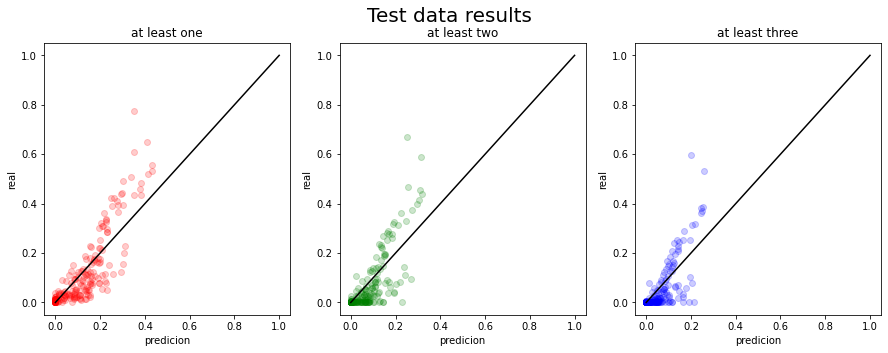

In [13]:
f = plt.figure(facecolor='white')
f.set_figwidth(15)
f.set_figheight(5)

plt.suptitle('Test data results', fontsize = 20)

plt.subplot(1,3,1)
plt.scatter(preds_test['at_least_one'], Y_test['at_least_one'], color='r', alpha=0.2,)
plt.title('at least one')
plt.plot([0,1],[0,1], 'k')
plt.xlabel('predicion')
plt.ylabel('real')

plt.subplot(1,3,2)
plt.scatter(preds_test['at_least_two'], Y_test['at_least_two'], color='g', alpha=0.2)
plt.title('at least two')
plt.plot([0,1],[0,1], 'k')
plt.xlabel('predicion')
plt.ylabel('real')

plt.subplot(1,3,3)
plt.scatter(preds_test['at_least_three'], Y_test['at_least_three'], color='b', alpha=0.2)
plt.title('at least three')
plt.plot([0,1],[0,1], 'k')
plt.xlabel('predicion')
plt.ylabel('real')

plt.show()

In [14]:
model.best_estimator_.coef_

array([[ 2.74484770e-02, -0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  7.07421736e-02,  0.00000000e+00,
        -0.00000000e+00,  2.34059441e-03, -1.71299468e-02,
         2.21807358e-02,  7.05008980e-02,  2.11814165e-02,
         7.14445008e-04, -5.39861578e-03, -7.89772795e-04,
        -3.12553414e-05,  6.72027853e-03, -2.43615838e-03,
        -6.50819630e-04,  0.00000000e+00, -3.40901484e-03,
        -4.26116989e-04, -3.53046382e-03, -4.99519105e-03,
         3.61587677e-03,  3.16158208e-03,  0.00000000e+00,
         0.00000000e+00,  4.59172116e-03, -0.00000000e+00,
         1.48530262e-04, -7.71650187e-03,  4.49876605e-04,
         1.26555980e-02, -0.00000000e+00,  6.56536483e-03,
         5.99318893e-04, -1.61344375e-03],
       [ 1.80016772e-02, -0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  6.06100099e-02,  0.00000000e+00,
        -0.00000000e+00,  1.41327325e-03, -9.35178685e-03,
         2.11245025e-02,  4.35431800e-02,  1.38183199e-02,
         4.17